# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [760]:
import pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [881]:
with open(r'D:\ucl\pyssem\scenario_properties_long.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)

In [882]:
scenario_properties.x0

,Su_260kg,Su_473kg,S_148kg,S_750kg,S_1250kg,sns,N_0.00141372kg,N_0.567kg,N_6kg,N_148kg,N_260kg,N_473kg,N_750kg,N_1250kg,B
alt_bin,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0
1,2,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,11,0,0,0,0,0,0,0,4,2,0,0,0,0,3
3,14,1,0,0,0,0,0,1,9,2,0,0,0,1,1
4,30,0,0,0,0,0,0,3,8,5,1,0,0,0,2
5,43,0,0,0,0,0,0,5,28,10,0,0,0,0,2
6,44,2,0,0,0,0,0,5,30,15,0,0,0,1,7
7,117,3,0,0,0,0,0,3,37,25,1,0,0,0,10
8,161,4,0,0,0,0,0,2,62,30,0,0,0,0,17


In [923]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

# Convert to symbols
print(len(symbols)) # Should be 320 for a 40, 8 matrix
print(symbols)

# Convert equations to lambda functions
equations = [sp.lambdify(symbols, eq, 'numpy') for eq in scenario_properties.equations]
# drag_only = [sp.lambdify(symbols, eq, 'numpy') for eq in scenario_properties.full_drag]
pmd_only = [sp.lambdify(symbols, eq, 'numpy') for eq in scenario_properties.full_Cdot_PMD]

600
[Su_260kg_1, Su_260kg_2, Su_260kg_3, Su_260kg_4, Su_260kg_5, Su_260kg_6, Su_260kg_7, Su_260kg_8, Su_260kg_9, Su_260kg_10, Su_260kg_11, Su_260kg_12, Su_260kg_13, Su_260kg_14, Su_260kg_15, Su_260kg_16, Su_260kg_17, Su_260kg_18, Su_260kg_19, Su_260kg_20, Su_260kg_21, Su_260kg_22, Su_260kg_23, Su_260kg_24, Su_260kg_25, Su_260kg_26, Su_260kg_27, Su_260kg_28, Su_260kg_29, Su_260kg_30, Su_260kg_31, Su_260kg_32, Su_260kg_33, Su_260kg_34, Su_260kg_35, Su_260kg_36, Su_260kg_37, Su_260kg_38, Su_260kg_39, Su_260kg_40, Su_473kg_1, Su_473kg_2, Su_473kg_3, Su_473kg_4, Su_473kg_5, Su_473kg_6, Su_473kg_7, Su_473kg_8, Su_473kg_9, Su_473kg_10, Su_473kg_11, Su_473kg_12, Su_473kg_13, Su_473kg_14, Su_473kg_15, Su_473kg_16, Su_473kg_17, Su_473kg_18, Su_473kg_19, Su_473kg_20, Su_473kg_21, Su_473kg_22, Su_473kg_23, Su_473kg_24, Su_473kg_25, Su_473kg_26, Su_473kg_27, Su_473kg_28, Su_473kg_29, Su_473kg_30, Su_473kg_31, Su_473kg_32, Su_473kg_33, Su_473kg_34, Su_473kg_35, Su_473kg_36, Su_473kg_37, Su_473kg_38,

In [884]:
full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [960]:
pmd_only[15](*x0_flattened)


-0.25

In [961]:
x0_flattened = scenario_properties.x0.T.values.flatten()

# Initial population needs to be in one columnn, so now the intiial population is in one. Species 1 is the first 40 rows, species 2 is the next 40 rows, etc.
def population_shell(t, N, full_lambda, equations):
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)
    
    # Iterate over each component in N
    for i in range(len(N)):
        # Compute the intrinsic rate of change from the differential equation
        dN_dt[i] = equations[i](*N)
        
        # Compute and add the external modification rate, if applicable
        lambda_value = full_lambda[i]
        if lambda_value is not None:
            # Add the lambda_value's contribution to the rate of change
            # Assume lambda_value is a function of time t
            increase = lambda_value(t)
            if increase is not None:
                print(increase, i, t, N[i])
                dN_dt[i] += increase
               
    return dN_dt

output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, args=(full_lambda_flattened, equations), t_eval=scenario_properties.scen_times, method='RK45')    

0 -0.25
1 -0.0
2 -0.0
3 -0.0
4 -0.0
5 -0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0875
11 0.0
12 0.0
13 0.0
14 0.0
15 -0.25
16 -0.0
17 -0.0
18 -0.0
19 -0.0
20 -0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0875
26 0.0
27 0.0
28 0.0
29 0.0
30 -1.375
31 -0.0
32 -0.0
33 -0.0
34 -0.0
35 -0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.48124999999999996
41 0.0
42 0.0
43 0.0
44 0.0
45 -1.75
46 -0.125
47 -0.0
48 -0.0
49 -0.0
50 -0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.6124999999999999
56 0.04375
57 0.0
58 0.0
59 0.0
60 -3.75
61 -0.0
62 -0.0
63 -0.0
64 -0.0
65 -0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 1.3125
71 0.0
72 0.0
73 0.0
74 0.0
75 -5.375
76 -0.0
77 -0.0
78 -0.0
79 -0.0
80 -0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 1.8812499999999999
86 0.0
87 0.0
88 0.0
89 0.0
90 -5.5
91 -0.25
92 -0.0
93 -0.0
94 -0.0
95 -0.0
96 0.0
97 0.0
98 0.0
99 0.0
100 1.9249999999999998
101 0.0875
102 0.0
103 0.0
104 0.0
105 -14.625
106 -0.375
107 -0.0
108 -0.0
109 -0.0
110 -0.0
111 0.0
112 0.0
113 0.0
114 0.0
115 5.1187499999999995
116 0.13124999999999998
11

In [953]:
scenario_properties.full_Cdot_PMD[15]

-0.125*Su_260kg_2

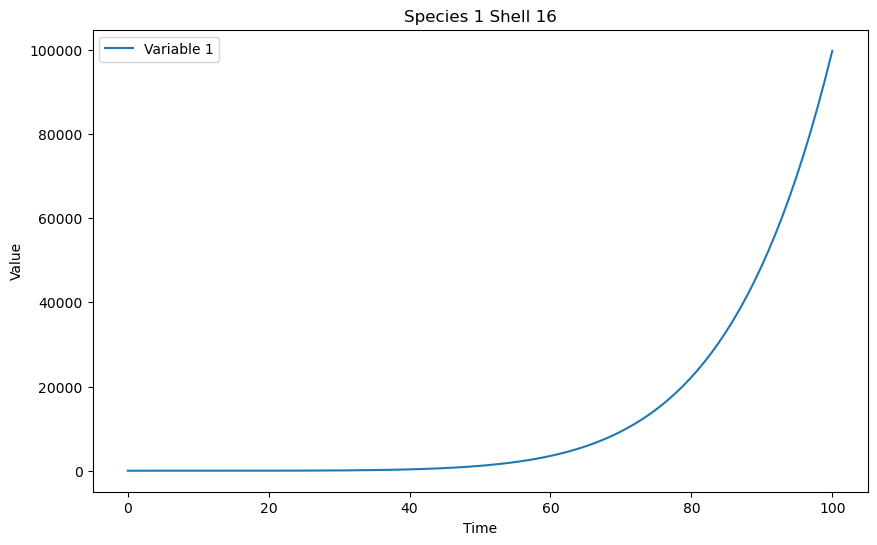

In [952]:
plt.figure(figsize=(10, 6))

# 'output.y' shape is (n_variables, n_timepoints)
# Loop over the first 10 rows (variables) if there are at least 10
n_plots = min(10, output.y.shape[0])

# for i in range(n_plots):
#     plt.plot(output.t, output.y[i, :], label=f'Variable {i+1}')

plt.plot(output.t, output.y[15, :], label='Variable 1')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Species 1 Shell 16')
plt.legend()
plt.show()

D:\TEMP\ipykernel_9284\3150393037.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


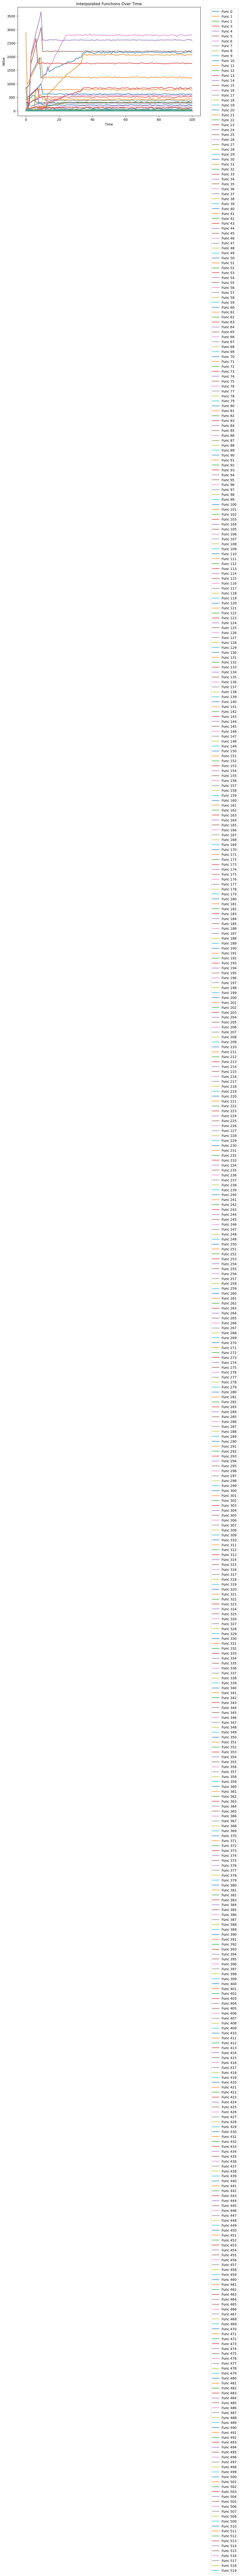

In [887]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.scen_times defines the time range for plotting
start_time, end_time = scenario_properties.scen_times[0], scenario_properties.scen_times[-1]
time_points = np.linspace(start_time, end_time, 100)  # Adjust the number of points as necessary

# Filter out None values from the list of interpolated functions
interpolated_functions = [f for f in full_lambda_flattened if f is not None]

# Plot each interpolated function
plt.figure(figsize=(10, 6))
for func in interpolated_functions:
    # Evaluate the function at each point in time_points
    values = func(time_points)
    
    # Plot the result
    plt.plot(time_points, values)

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Interpolated Functions Over Time')
plt.legend([f'Func {i}' for i, _ in enumerate(interpolated_functions)], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [865]:
def run_simulation():
    from scipy.integrate import solve_ivp
    
    def population_shell(t, N, full_lambda, equations):
        dN_dt = np.zeros_like(N)
        for i in range(len(N)):
            dN_dt[i] = equations[i](*N)
            lambda_value = full_lambda[i]
            if lambda_value is not None:
                dN_dt[i] += lambda_value(t)
        return dN_dt

    output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], 
                       x0_flattened, args=(full_lambda_flattened, equations), 
                       t_eval=scenario_properties.scen_times, method='RK23')
    return output

import cProfile
import pstats

# Create a Profile object and run the run_simulation function
profiler = cProfile.Profile()
profiler.enable()

run_simulation()

profiler.disable()
# Create Stats object
stats = pstats.Stats(profiler).sort_stats('cumtime')

# Print the stats report to the console
stats.print_stats()


KeyboardInterrupt: 